<a href="https://colab.research.google.com/github/2pterons/multicampus/blob/main/2_20211005_KoGPT2_idiom_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **⦁ GPT** 구조

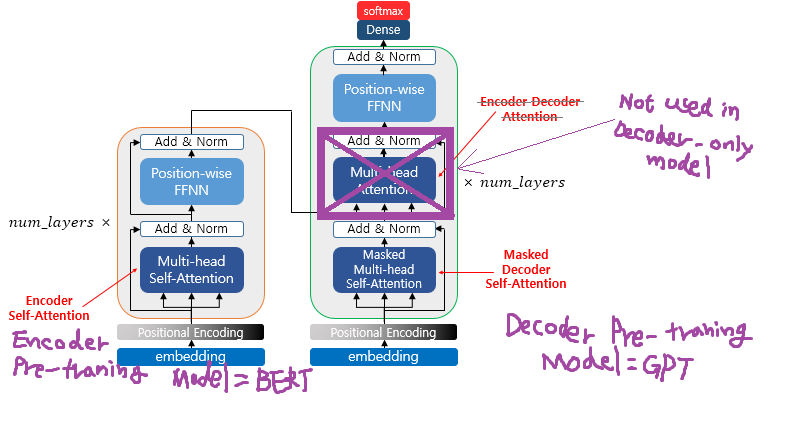

<br/><br/>

# **KoGPT2를 이용한 감성분석**
<br/>


### 1. 라이브러리 설치 및 임포트

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


In [ ]:
!pip install --upgrade mxnet>=1.6.0
!pip install gluonnlp
!pip install transformers
!pip install sentencepiece

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer, SentencepieceDetokenizer
from transformers import TFGPT2LMHeadModel
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

<br/><br/>
### 2. pickle을 이용해 final_idiom_dataset_for_ko.pkl 읽어오기 및 변수에 담기

In [ ]:
import pickle
#with open('./final_idiom_dataset_for_ko.pkl', 'rb') as f:
with open('./2/train_34614.pkl','rb') as f:
  text = pickle.load(f)

In [ ]:
text.head()

ko  Label
0           그럼에도 불구하고 올림픽에서 가장 멋진 부분 중 하나는 바로 사진입니다.      1
1       식당에 종사하는 사람은 위생복을 착용하여야 하며, 항상 청결을 유지하여야 한다.      0
2  대법원 1부(주심 권순일 대법관)는 28일 강아무개씨 등 정보유출 피해자 341명이...      0
3  경제전문가들은 후반기에 경기가 좀 좋아진다 하더라도 연말까지 400억 헤알에 달하는...      0
4  이 자리에서 이 대표는 “일자리 문제가 어려운데 당에서도 민생연석회의 출범을 조만간...      1

In [ ]:
data = text['ko']
data.head()

0             그럼에도 불구하고 올림픽에서 가장 멋진 부분 중 하나는 바로 사진입니다.
1         식당에 종사하는 사람은 위생복을 착용하여야 하며, 항상 청결을 유지하여야 한다.
2    대법원 1부(주심 권순일 대법관)는 28일 강아무개씨 등 정보유출 피해자 341명이...
3    경제전문가들은 후반기에 경기가 좀 좋아진다 하더라도 연말까지 400억 헤알에 달하는...
4    이 자리에서 이 대표는 “일자리 문제가 어려운데 당에서도 민생연석회의 출범을 조만간...
Name: ko, dtype: object

In [ ]:
target = text['Label']
target.head()

0    1
1    0
2    0
3    0
4    1
Name: Label, dtype: int64

<br/><br/>
### pre-training 데이터


In [ ]:
dx_train,dx_test, dy_train, dy_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

MY_PATH = '/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/'
MODEL_PATH = MY_PATH + 'gpt_ckpt'
TOKENIZER_PATH = MY_PATH + 'gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, num_best=0, alpha=0)
detokenizer = SentencepieceDetokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token = None,
                                               sep_token = None,
                                               cls_token = None,
                                               unknown_token = '<unk>',
                                               padding_token = '<pad>',
                                               bos_token = '<s>',
                                               eos_token = '</s>')
# vocab --> Vocab(size=50000, unk="<unk>", reserved="['<pad>', '<s>', '</s>']")


In [ ]:
MAX_LEN = 60
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)


In [ ]:
x_train, y_train = build_data(dx_train, dy_train)
x_test, y_test = build_data(dx_test, dy_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((27691, 62), (27691, 1), (6923, 62), (6923, 1))

In [ ]:
x_test[0]


array([    0, 12277,  6768,  7810,  1079, 19593,   394,  4268,   351,
        9784,   961, 47445,   126, 47535, 47616, 47454,  2863, 11630,
       28761,   244,   369, 47464,  7312,  3975, 47611,   330, 47440,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     1])

In [ ]:
len(x_test[0])

62

In [ ]:
print(len(vocab))
print(vocab.padding_token, ':', vocab[vocab.padding_token])
print(vocab.bos_token, ': ', vocab[vocab.bos_token])
print(vocab.eos_token, ': ', vocab[vocab.eos_token])
print(vocab.unknown_token, ': ', vocab[vocab.unknown_token])


50000
<pad> : 3
<s> :  0
</s> :  1
<unk> :  5


In [ ]:
word2idx = {k:v for k, v in vocab.token_to_idx.items()}
idx2word = {v:k for k, v in word2idx.items()}
idx2word[5000]


'▁전세'

In [ ]:
# 참고 : https://nlp.gluon.ai/api/modules/data.html
tokenizer('나는 자연어처리를 공부하고 있다')

print([idx2word[i] for i in x_test[0]])

['<s>', '▁사용자가', '▁별도의', '▁설비', '▁또는', '▁기기를', '▁사용', '하고자', '▁할', '▁때에는', '▁별', '지', '▁제', '6', '호', '서', '식에', '▁의하여', '▁구청장', '에게', '▁검', '인', '▁신청을', '▁하여', '야', '▁한다', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '</s>']


In [ ]:
gpt_model = TFGPT2LMHeadModel.from_pretrained(MODEL_PATH)
gpt_model.summary()


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#pre-trainmodel
# TFGPT2MainLayer는 fine-tuning을 하지 않는다.
gpt_model.trainable = True
gpt_model.summary() # gtp_model을 다시 확인한다. trainable params = 0


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# GPT2 입력
# ---------
x_input = Input(batch_shape = (None, MAX_LEN + 2), dtype = tf.int32)


In [ ]:
# GPT2 출력
# ---------
# output_gpt[0]        --> <KerasTensor: shape=(None, 60, 50000) dtype=float32
# output_gpt[0][:, -1] --> <KerasTensor: shape=(None, 50000) dtype=float32
output_gpt = gpt_model(x_input)[0][:, -1]


In [ ]:
# Downstream task : idiom classifier
# -------------------------------------
# 사전학습데이터 없이 Dense Layer만 붙여놓은것
y_output = Dense(1, activation = 'sigmoid')(output_gpt)
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 2e-5))
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model (TFGPT2 TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 124,292,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=128)

Epoch 1/3
217/217 [==============================] - 261s 1s/step - loss: 0.6098 - val_loss: 0.3727
Epoch 2/3
217/217 [==============================] - 241s 1s/step - loss: 0.2629 - val_loss: 0.1859
Epoch 3/3
217/217 [==============================] - 241s 1s/step - loss: 0.1611 - val_loss: 0.1467


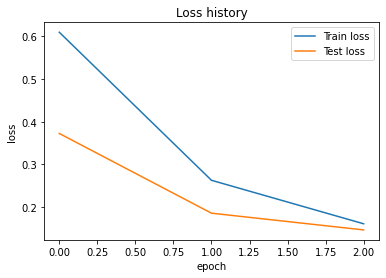

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
gpt_model.trainable = False
gpt_model.summary()

Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 0
Non-trainable params: 124,242,432
_________________________________________________________________


In [ ]:
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-6))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model (TFGPT2 TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 50,001
Non-trainable params: 124,242,432
_________________________________________________________________


In [ ]:
x_train

array([[    0,   167,  1286, ...,     3,     3,     1],
       [    0,   427, 10066, ...,     3,     3,     1],
       [    0,  2143, 47453, ...,     3,     3,     1],
       ...,
       [    0,   512,   232, ...,     3,     3,     1],
       [    0,   568, 36132, ...,     3,     3,     1],
       [    0, 14504, 10120, ...,     3,     3,     1]])

In [ ]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=128)

Epoch 1/3
217/217 [==============================] - 112s 453ms/step - loss: 0.1237 - val_loss: 0.1360
Epoch 2/3
217/217 [==============================] - 95s 439ms/step - loss: 0.1227 - val_loss: 0.1350
Epoch 3/3
217/217 [==============================] - 95s 439ms/step - loss: 0.1217 - val_loss: 0.1352


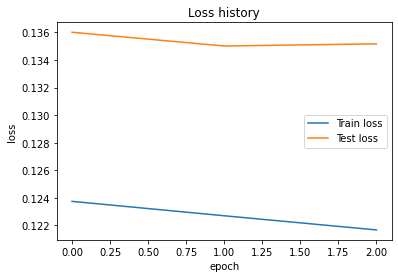

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


In [ ]:
"""from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬
# 정확도
print("accuracy:", accuracy_score(y_test, y_pred))

# 정밀도
print("precision:", precision_score(y_test, y_pred))

# 재현율
print("recall:", recall_score(y_test, y_pred))

# f1-score
print("F1-Score:", f1_score(y_test, y_pred))"""

'from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix\n# 오차행렬\n# 정확도\nprint("accuracy:", accuracy_score(y_test, y_pred))\n\n# 정밀도\nprint("precision:", precision_score(y_test, y_pred))\n\n# 재현율\nprint("recall:", recall_score(y_test, y_pred))\n\n# f1-score\nprint("F1-Score:", f1_score(y_test, y_pred))'

In [ ]:
# 새로운 문장으로 테스트
#new_test = pd.read_csv('./idiom_dataset(18808).csv')
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data
import pickle
with open('./1/test_3000.pkl', 'rb') as f:
  new_test = pickle.load(f)
new_test

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


ko  Label
0     더 큰 문제는 자영업자들이 상황을 타개하기 위해 부채를 확대하고 있어 잠재부실에 대...      0
1                         팝콘이랑 콜라 쓰레기는 버리고 오지 왜 들고 다니니?      0
2     삼성전자의 가시적인 목표는 파운드리 분야에서 대만 TSMC를 따라잡고, AP와 모뎀...      1
3     그런 만큼 이 시점에 우리 정부가 적극 개입해 북-미 사이에 다리를 놓는 것도 필요...      1
4     김 후보자는 개성공단 재개에 대한 원유철 자유한국당 의원의 질의에는 “지금 상황에서...      1
...                                                 ...    ...
2995  마이크론은 글로벌 D램 시장에서 삼성전자와 SK하이닉스에 이어 점유율 3위 업체로 ...      1
2996  데이식스는 위촉식에서 “KYWA가 추진하는 청소년 관련 행사 및 홍보 활동에 적극 ...      0
2997             머리끝에 상판을 제외하고 그곳에는 상부구조가 없었던 거처럼 보입니다.      0
2998  색다른 매력을 지닌 배우들과 개성 있는 이야기가 한 데 어우러져 안방극장을 뜨겁게 ...      0
2999  포상금을 지급 받으려고 하는 사람은 별지 제1호서식의 포상금 지급신청서를 구청장에게...      0

[3000 rows x 2 columns]

In [ ]:
#new_test['Label'] = 1

In [ ]:
new_test['ko'][10]
new_test = new_test.sample(frac=1).reset_index(drop=True)
new_test

ko  Label
0     예비역 장성 마크 허틀링은 트럼프 대통령이 구상한 방위비분담금 인상안에 대해 “그것...      0
1     실제 국토교통부 자료에 따르면 지난해 전국 단독주택 거래량은 16만2673건으로 정...      0
2                       그런데 어느 누구도 이 안에서 다른 것을 듣지 않았어요.      1
3                            기압이 낮아지고 있어요, 모두 대피시켜야 해요.      0
4     당초 강 위원장은 국정감사에서 이 문제가 불거지자 “감사원 감사를 받겠다”며 버텼지...      1
...                                                 ...    ...
2995                              그럼 이 크림치즈 스파게티는 어떠세요?      0
2996                         하지만 혹시 모르니 병원에 찾아가는 게 좋겠죠?      1
2997  규정상 내려줄 수 없었다고 하는데 이렇게 사람 진 빠지게 하는 규정이 맞는 건지, ...      1
2998                    첫 번째는 원외위원장들이 뼈 빠지게 하고 있기 때문이다.      1
2999              생각과 행동이 막다른 골목에 부닥치면 그걸 돌파하려고 애를 씁니다.      1

[3000 rows x 2 columns]

In [ ]:
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)

In [ ]:
new_test_text, _ = build_data(new_test['ko'], np.zeros(len(new_test)))
answer = new_test.Label.to_list()
len(answer)
# 시험 데이터로 학습 성능을 평가한다
new_pred = model.predict(new_test_text)
new_y_pred = np.where(new_pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [ ]:
new_y_pred.sum()

1504

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬

# 정확도
print("accuracy:", accuracy_score(answer, new_y_pred))

# 정밀도
print("precision:", precision_score(answer, new_y_pred))

# 재현율
print("recall:", recall_score(answer, new_y_pred))

# f1-score
print("F1-Score:", f1_score(answer, new_y_pred))

accuracy: 0.934
precision: 0.932845744680851
recall: 0.9353333333333333
F1-Score: 0.9340878828229027


In [ ]:
df = pd.DataFrame({'ko':new_test['ko'], 'Label':list(new_y_pred.reshape(-1,1))})

In [ ]:
for i in df[df['Label']==1]['ko']:
  print(i)

당초 강 위원장은 국정감사에서 이 문제가 불거지자 “감사원 감사를 받겠다”며 버텼지만 즉각 사퇴로 가닥을 잡았다.
해외 대학 컨설팅 전문가들은 좀 더 인상적인 에세이를 작성하기 위해서는 꾸준한 독서와 학습, 그리고 훈련이 필요하다고 입을 모아 말한다.
제네시스가 북미에서 진땀을 흘리는 사이 데뷔 첫 해만에 누적 1만대를 돌파하며 스포츠 세단으로서 입지를 다진 것도 이유가 있을 테다.
국내 최초로 선보이는 크리쳐 액션 사극이 향후 한국영화의 장르 확장에 얼마나 큰 기여를 할 수 있을지 관객들과 관계자의 눈과 귀가 쏠리고 있다.
지난해부터 중앙정부와 지방자치단체, 지역주민이 머리를 맞대고 공공 유휴공간을 민간이 활용할 수 있도록 추진한 사업이 결실을 맺은 것이다.
우리 부처님께서 가만히 계시면 임금이 될 것인데 모든 걸 버리고 우리 어머님, 아버님들을 대자대비로, 사랑으로 찾아뵙기 위해 몸을 던지셨다.
그는 “제가 기재위에서 기획재정부를 엄청 쪼아서 ‘예산편성지침’에 양극화 해소를 집어넣었는데 오히려 문재인 정부 들어서고 나서 그 양극화 해소 편성 지침이 슬그머니 뒤로 빠졌다”고 했습니다.
어찌보면 아시아 최강을 가리기위한 치열한 경쟁에서 나올 수 있는 부분이긴 하지만 일부 선수들의 도를 넘는 비매너와 폭력 행위는 팬들의 눈살을 찌푸리게 했다.
바람 쐬러 연천에 다녀왔어요.
예컨대 발을 뻗다 실수로 잠자는 개를 깨웠을 때, 개가 화를 내주면 덜 미안할 텐데 오히려 개가 미안해한다.
송희경 의원은 전날 열린 한국당 비상의원총회에서 “임 의원이 심각한 정서적 쇼크로 병원에 갔다”며 말문을 열었다.
영세 자영업자와 한계 자영업자의 숨통을 틔워줄 정책적 지원이 절실하다.
유백이 분교에 차려진 허름하고 어수선한 보건소의 광경에 넋을 놓던 중 아서라(이아현 분)가 엘리트 의사 포스를 뽐내며 우아하게 등장했다.
앞서 지난 7월에는 김선수·노정희 대법관 후보자가 다운계약서 작성, 위장전입 이력에 대한 해명과 사과에 진땀을 빼야 했다.
국내 카드사 중에 BC카드가 최초로 포문을 

In [ ]:
for i in df[df['Label']==0]['ko']:
  print(i)

예비역 장성 마크 허틀링은 트럼프 대통령이 구상한 방위비분담금 인상안에 대해 “그것은 완전히 백치 같은 짓”이라고 강하게 비판했다.
실제 국토교통부 자료에 따르면 지난해 전국 단독주택 거래량은 16만2673건으로 정부가 거래 통계를 낸 이후 최대치를 기록했다.
그런데 어느 누구도 이 안에서 다른 것을 듣지 않았어요.
기압이 낮아지고 있어요, 모두 대피시켜야 해요.
도지사는 주재국 상황을 고려하여 해외주재 정부 및 공공기관, 현지 정부기관 등에 공무원을 파견하는 형태로 본부를 운영할 수 있다.
도내 중소기업의 세계시장 진출을 위해 러시아 원천기술 시장 공약에 나선 경기도 실무단이 3백만 불 규모 투자유치에 성공했다.
이 사례들을 통해서 우리가 알 수 있는 건 한 가지다.
이날 행사는 경기도곤충산업연구회 회원 55명, 곤충사육농가 관계자 5명 등 총 60명이 참석한 가운데 곤충산업의 육성방안과 알아야 할 법 규정, 올해 육성계획을 다뤘다.
극중 비서관과의 불륜이 최근 사회적인 이슈가 된 안희정 전 충남지사의 성추문을 연상시키기도 해 박해일과 ‘상류사회’를 바라보는 시선에 궁금증을 더 담게 한다.
호르헤 로발요 주한 아르헨티나 대사가 10일 경남도청을 찾아 상호 교류 협력과 공동 발전을 위한 방안을 논의했다.
심석희의 법률대리인 세종은 지난 8일 “조재범 전 코치는 상하관계에 따른 위력을 이용해 선수를 폭행·협박한 뒤 선수가 만 17세였을 때부터 4년간 상습적인 성폭행을 저질렀다”고 말했다.
내가 그렇게 잘못한 것입니까?
문 대통령의 이름은 기조 연설과 김씨가 댓글 작업을 한 기사 목록의 제목 등때문에 등장한 정도다.
파일을 확인하였는데 출장 경비를 어떤 기준으로 작성하셨나요?
구청장은 관리주체에게 감사결과를 통보 받은 날부터 10일 이내에 해당 공동주택 단지의 인터넷 홈페이지 등에 그 결과를 공개하게 할 수 있다.
기분 좋은 봄 햇살을 닮은 김재경의 ‘초면에 사랑합니다’ 포스터 촬영 현장 비하인드 영상이 공개돼 눈길을 끌고 있다.
면허취소 후 사법절차에서 질 것이

In [ ]:
%cd /content/drive/MyDrive

MODEL_PATH = "/Colab Notebooks/multicampus/Idiom Classifier/data/kogpt2_11710"
model.save(MODEL_PATH)

/content/drive/MyDrive


INFO:tensorflow:Assets written to: /Colab Notebooks/multicampus/Idiom Classifier/data/kogpt2_11710/assets


INFO:tensorflow:Assets written to: /Colab Notebooks/multicampus/Idiom Classifier/data/kogpt2_11710/assets


In [ ]:
pwd

'/content/drive/My Drive/Colab Notebooks/multicampus/Idiom Classifier/data'